# Amazon Bedrock Multimodal Examples

## This notebook demonstrates invoking Bedrock models programmatically with the boto3 SDK

## Example 1 Generate baked good menu ideas and images for a bakery website
## Example 2 Analyze images and explore prompting techniques for improved responses


## Prerequisites
### Enable AWS IAM permissions for Bedrock

To grant Bedrock access to your identity, you can:

- Open the AWS IAM Console 
- Find your role if using SageMaker or otherwise assuming an IAM Role), or user
- Select *Add Permissions > Create Inline Policy* to attach new inline permissions, open the *JSON* editor and paste in the below example policy:

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "BedrockFullAccess",
            "Effect": "Allow",
            "Action": ["bedrock:*"],
            "Resource": "*"
        }
    ]
}
```

> ⚠️ **Note:** With Amazon SageMaker, your notebook execution role will typically be *separate* from the user or role that you log in to the AWS Console with. If you'd like to explore the AWS Console for Amazon Bedrock, you'll need to grant permissions to your Console user/role too.

For more information on the fine-grained action and resource permissions in Bedrock, check out the Bedrock Developer Guide.


## Setup 

In [1]:
# Uncomment the below and run if those packages are not already installed

# %pip install --no-build-isolation --force-reinstall \
#     "boto3>=1.28.57" \
#     "awscli>=1.29.57" \
#     "botocore>=1.31.57"
# %pip install "unstructured[csv]" "pillow>=9.5,<10" langchain==0.0.309 python-weather pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet

### Restart kernel before proceeding


### Create the bedrock client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. 

### Use a different AWS Region

If you're running SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.


In [1]:
# Import necessary libraries
import json
import os
import sys
import boto3
import botocore

# Set the module path for importing utils
module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# Set the AWS region for your resources
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

# Uncomment and set your AWS profile if needed
# os.environ["AWS_PROFILE"] = ""

# Uncomment and set the AWS role ARN for assuming a role if needed
# os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

# Get the Bedrock client for interacting with the Bedrock runtime
bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

# Set the model parameters for the Bedrock runtime
# These parameters control the behavior of the language model
# temperature: Controls the randomness of the output. 1.0 means creative outputs, but less coherent.
# top_p: Consider the most probable tokens that make up a certain percentage of the total probability mass.(0.5 means top 50% of the distribution)
# max_tokens_to_sample: Maxi number of tokens (words or subwords) the model should generate when producing output text
model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

Create new client
  Using region: us-west-2
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


In [2]:
# Create the prompt
customer_input="I am the owner of a bakery that offers cakes, muffins, breads, cookies and coffee drinks. I want weekly baked goods menu ideas for my store and for showcasing on my website?"

## Example 1 Generate baked good menu ideas and images for a bakery website

### Generate the baked goods menu

In [3]:
# Define the prompt for the model
# The "Human:" part provides the initial instruction 
# the "Assistant part indicates where the assistant should start generating its response.

prompt = """
Human: list different baked goods options for:
""" + customer_input + """

Assistant:"""
# Convert the prompt to a JSON string
body = json.dumps({"prompt": prompt, "max_tokens_to_sample": 500})

# Set the model ID (change this to use a different version from the model provider)
modelId = "anthropic.claude-v2"

# Set the accepted response format and content type
accept = "application/json"
contentType = "application/json"

# Invoke the Bedrock model with the provided parameters
response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)

# Parse the response body from the model
response_body = json.loads(response.get("body").read())

# Extract the model's completion from the response
baked_goods_response = response_body.get("completion")

# Print the model's response
print(baked_goods_response)


 Here are some weekly baked goods menu ideas for your bakery:

Monday:
- Featured cake: Red velvet cake with cream cheese frosting
- Muffin flavors: Blueberry, banana nut, lemon poppyseed
- Loaf bread flavors: Cinnamon raisin, olive, rosemary
- Cookie flavors: Chocolate chip, snickerdoodle, peanut butter 

Tuesday:  
- Featured cake: Strawberry shortcake 
- Muffin flavors: Cranberry orange, corn, chocolate chip
- Loaf bread flavors: Asiago cheese, jalapeno cheddar, honey whole wheat
- Cookie flavors: Oatmeal raisin, ginger molasses, cowboy (oats, coconut, chocolate chips)

Wednesday: 
- Featured cake: German chocolate cake
- Muffin flavors: Pumpkin, apple cinnamon, mixed berry 
- Loaf bread flavors: Rustic white, multigrain, sun-dried tomato and herb
- Cookie flavors: Sugar, macadamia white chocolate, double chocolate 

Thursday:
- Featured cake: Carrot cake with cream cheese frosting
- Muffin flavors: Peach, lemon blueberry, coffee cake
- Loaf bread flavors: Country white, whole grain

### Generate the baked goods images


In [4]:
# Split the model's response into lines and remove empty lines
baked_goods_lines = list(filter(None, baked_goods_response.splitlines()))

# Remove the first and last lines (which are headers or footers)
baked_goods = [s.strip() for s in baked_goods_lines[1:-1]]

# Print each baked goods option on a new line
#print (len(baked_goods))
#print(*baked_goods, sep='\n')

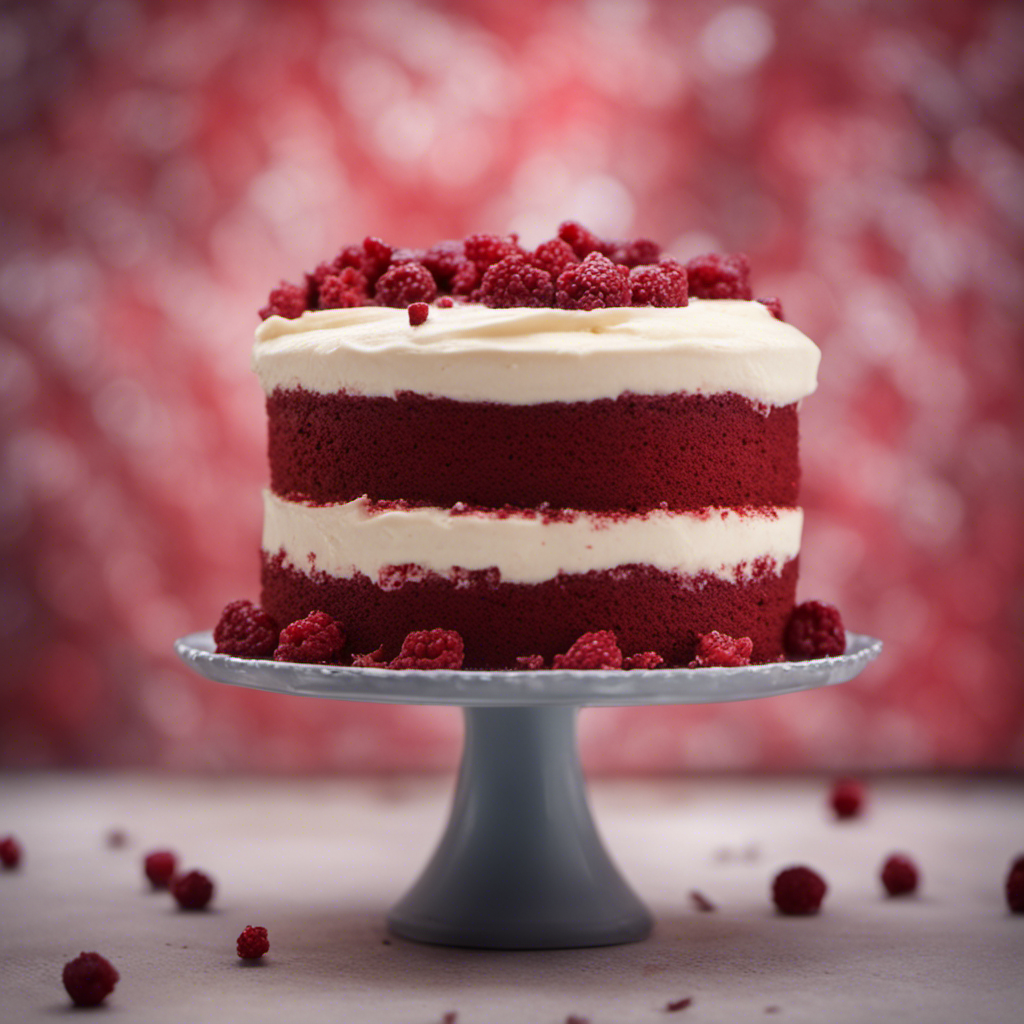

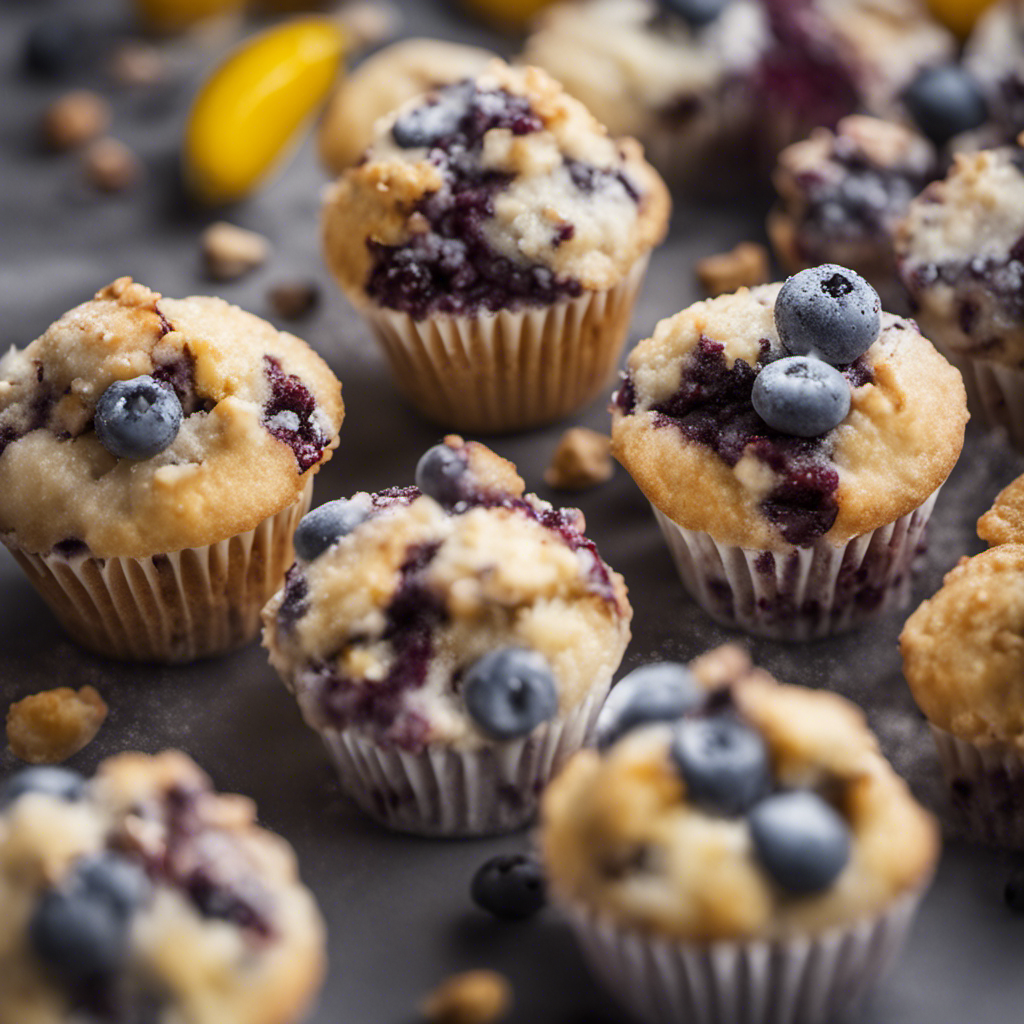

In [6]:
from PIL import Image
from IPython import display
from base64 import b64decode
import base64
import io
import json
import os
import sys

# Fetching baked goods images

#os.makedirs("data", exist_ok=True)  # Create a "data" directory if it doesn't exist
images = []  # Initialize an empty list to store images

for i, item in enumerate(baked_goods):
    if i >= 3:  # Stop after generating x images
        break

    if len(item.split("-")) > 1:
        # Prepare the request for generating an image
        request = json.dumps({
            "text_prompts": (
                [{"text": "baked good " + item.split("-")[1], "weight": 1.0}]
            ),
            "cfg_scale": 5,
            "seed": 5450,
            "steps": 70,
            "style_preset": "photographic",
        })
        modelId = "stability.stable-diffusion-xl-v1"  # Set the model ID

        # Invoke the Bedrock model to generate the image
        response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
        response_body = json.loads(response.get("body").read())

        # Extract the base64-encoded image string from the response
        base_64_img_str = response_body["artifacts"][0].get("base64")

        # Display the image
        display.display(display.Image(b64decode(base_64_img_str), width=500))

## Example 2 Ask questions about images and explore prompting techniques for improved responses

In [7]:
# Import necessary libraries
# base64: for encoding/decoding base64 data
# boto3: the AWS SDK for Python, used to interact with AWS services
# json: for working with JSON data
# IPython.display: for displaying images in Jupyter Notebooks

import base64
import boto3
import json
from IPython.display import Image


# Create a Bedrock client using the boto3 library
# This client will be used to interact with the Bedrock runtime service
bedrock_client = boto3.client('bedrock-runtime', region_name='us-west-2')


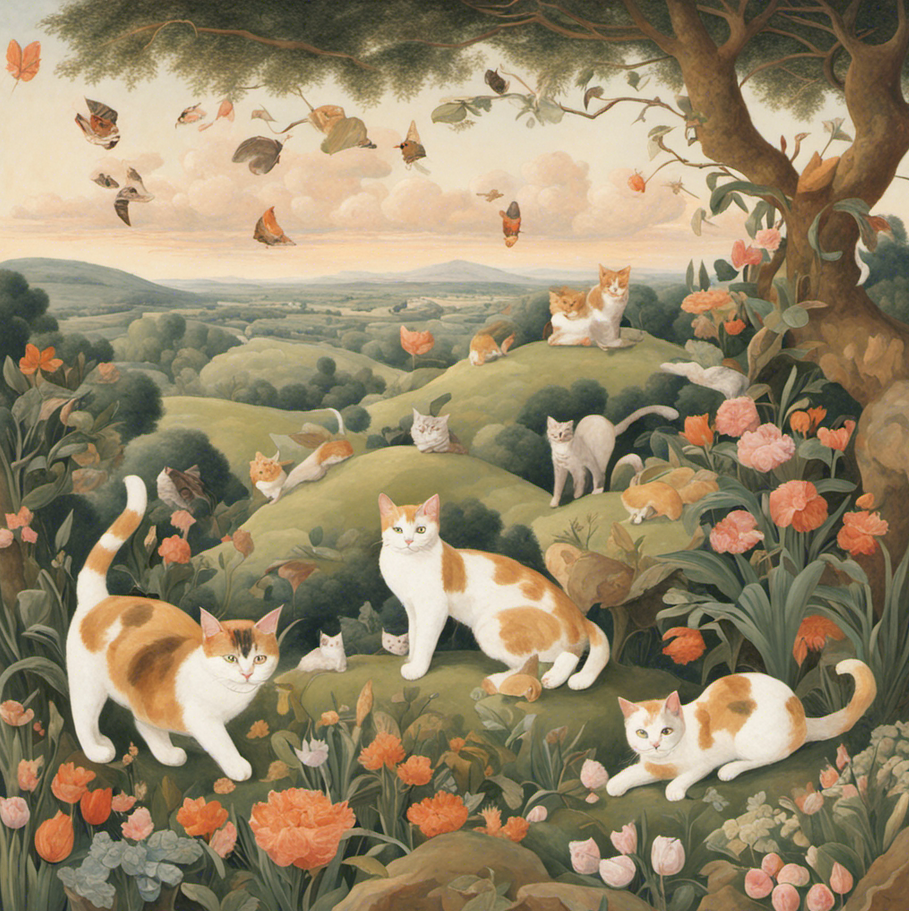

In [8]:
# Display the image
Image(filename='image.PNG') 

In [9]:
# Open the image file named 'image.PNG' in binary read mode
with open('image.PNG', "rb") as image_file:
    # Read the binary data from the image file
    content_image = base64.b64encode(image_file.read()).decode('utf8')
    


In [10]:
# Generate a response message using the Bedrock runtime and a specified model.
def generate_message(bedrock_runtime, model_id, messages, max_tokens, top_p, temp):
    # Create the request body as a JSON string
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",  # Specify the Anthropic version
            "max_tokens": max_tokens,  # Set the maximum number of tokens to generate
            "messages": messages,  # Include the conversation history
            "temperature": temp,  # Set the temperature value for the model
            "top_p": top_p  # Set the top-p sampling value for the model
        }
    )

    # Invoke the Bedrock model with the request body
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    # Parse the response body as JSON
    response_body = json.loads(response.get('body').read())

    # Return the response body
    return response_body

In [11]:
message_mm=[

    { "role": "user",
      "content": [
      {"type": "image","source": { "type": "base64","media_type":"image/jpeg","data": content_image}},
      {"type": "text","text": "What is in this image?"}
      ]
    }
]

In [12]:
generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)

{'id': 'msg_bdrk_01JjaUiYfBakedtjbr54iHDx',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-sonnet-20240229',
 'content': [{'type': 'text',
   'text': "This image depicts a whimsical, idyllic scene with numerous cats amidst a lush, flowering landscape. The foreground shows several orange and white cats lounging or wandering among vibrant orange, pink, and white flowers and foliage. The background reveals a rolling, hilly countryside with trees and a serene sky with falling autumn leaves. The overall atmosphere is tranquil and harmonious, with the cats appearing content and at home in their natural surroundings filled with blooming flora. The artistic style has a dreamy, illustrative quality that creates a sense of peace and appreciation for nature's beauty intertwined with the endearing presence of the feline subjects."}],
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'usage': {'input_tokens': 1106, 'output_tokens': 147}}

In [15]:
def get_base64_encoded_image(image_path):
   
    with open(image_path, "rb") as image_file:
        # Open the image file in binary read mode
        binary_data = image_file.read()
        # Read the binary data from the image file
        base_64_encoded_data = base64.b64encode(binary_data)
        # Encode the binary data as a base64 string
        base64_string = base_64_encoded_data.decode('utf-8')
        # Decode the base64 string to a UTF-8 string
        return base64_string
        # Return the base64-encoded string representation of the image

def generate_message(bedrock_runtime, model_id, messages, max_tokens=512, top_p=1, temp=0.5, system=''):
    # Create the request body as a JSON string
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",  # Specify the Anthropic version
            "max_tokens": max_tokens,  # Set the maximum number of tokens to generate
            "messages": messages,  # Include the conversation history
            "temperature": temp,  # Set the temperature value for the model
            "top_p": top_p,  # Set the top-p sampling value for the model
            "system": system  # Set the system message or instructions for the model
        }
    )

    # Invoke the Bedrock model with the request body
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    # Parse the response body as JSON
    response_body = json.loads(response.get('body').read())

    # Return the response body
    return response_body

In [16]:
# Create the message list
message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": get_base64_encoded_image("image.PNG")}},
            {"type": "text", "text": "How many cats are in this picture?"}
        ]
    }
]
# Generate the response message
response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0.5,top_p=0.9)
print(response['content'][0]['text'])

I can see at least 10 cats depicted in this beautiful illustration. The cats are scattered among rolling green hills, an old tree with falling autumn leaves, and lush floral gardens filled with orange, pink, and white flowers resembling tulips and carnations. The cats themselves have calico and tabby coat patterns in shades of orange, white, and brown. The idyllic pastoral scene has a warm, dreamy quality to it.


### Apply chain of thought prompting to new message

In [17]:

message_list = [
    {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": get_base64_encoded_image("image.PNG")}},
            {"type": "text", "text": "Exactly how many cats are in this picture? Count all cats including those hidden in the landscape. Before providing the answer in <answer> tags, think step by step in <thinking> tags and analyze every part of the image."}
        ]
    }
]

# Generate the response message
response=generate_message(bedrock_client, model_id = "anthropic.claude-3-sonnet-20240229-v1:0",messages=message_list,max_tokens=512,temp=0.5,top_p=0.9)
print(response['content'][0]['text'])

Okay, let me carefully analyze the image step-by-step to count all the cats:
<thinking>
1. I see a group of orange and white cats sitting prominently in the foreground on some hills, surrounded by flowers. There appear to be around 8-10 cats in this main group.
2. Looking closer at the tree on the left, I notice a couple more white cats sitting on branches among the leaves and falling leaves.
3. Scanning the landscape hills in the background, I can make out a few more white cat shapes sitting or walking on the hills.
4. I will systematically go through the image section by section to count each distinct cat shape I can identify.
</thinking>

<answer>
After a careful analysis, I count a total of 16 distinct cats in this illustration.
</answer>
